## EDA
### Purpose
There are few purpose of the EDA process.
- Find out how the distributions really are
- Choose which metrics to use and set the model's performance threshold
- Find out how to reconsist the data for training and visualize


In [1]:
import datetime
import os
import sys
import pathlib

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = '/content/drive/MyDrive/projects/data-hanmadang/Online Retail.xlsx'
dir_path = pathlib.Path(dir_path)

if os.path.exists(dir_path):
    if os.path.isdir(dir_path):
        os.chdir(dir_path)
        file_lt = os.listdir('./')
        df_lt = [pd.read_excel(i) for i in file_lt if i.endswith('.xlsx')]
        df = pd.concat(df_lt, axis=0)
    else:
        df = pd.read_excel(dir_path)

    df.head(), df.shape

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df.shape

(541909, 8)

### Drop anomal data
- CustomerID is missing
- Price or Quantity is not bigger than 0

In [6]:
df = df[~ df['CustomerID'].isna()]
df.shape

(406829, 8)

In [7]:
df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]
df.shape

(397884, 8)

In [8]:
total_df = df

In [9]:
df = total_df

In [10]:
df = df[['InvoiceNo', 'StockCode', 'InvoiceDate', 'Quantity']]
df.head()

,InvoiceNo,StockCode,InvoiceDate,Quantity
0,536365,85123A,2010-12-01 08:26:00,6
1,536365,71053,2010-12-01 08:26:00,6
2,536365,84406B,2010-12-01 08:26:00,8
3,536365,84029G,2010-12-01 08:26:00,6
4,536365,84029E,2010-12-01 08:26:00,6


In [11]:
df = df.rename(columns={'InvoiceNo': '주문코드', 'StockCode': '상품명', 'InvoiceDate': '주문일자', 'Quantity': '수량'})
df.head()

,주문코드,상품명,주문일자,수량
0,536365,85123A,2010-12-01 08:26:00,6
1,536365,71053,2010-12-01 08:26:00,6
2,536365,84406B,2010-12-01 08:26:00,8
3,536365,84029G,2010-12-01 08:26:00,6
4,536365,84029E,2010-12-01 08:26:00,6


In [12]:
df.head()

,주문코드,상품명,주문일자,수량
0,536365,85123A,2010-12-01 08:26:00,6
1,536365,71053,2010-12-01 08:26:00,6
2,536365,84406B,2010-12-01 08:26:00,8
3,536365,84029G,2010-12-01 08:26:00,6
4,536365,84029E,2010-12-01 08:26:00,6


In [13]:
df['주문일자'] = pd.to_datetime(df['주문일자'], format='%Y-%m-%d %H:%M')

In [14]:
df['ordered_day'] = pd.to_datetime(df['주문일자'].dt.date)
df.head()

,주문코드,상품명,주문일자,수량,ordered_day
0,536365,85123A,2010-12-01 08:26:00,6,2010-12-01
1,536365,71053,2010-12-01 08:26:00,6,2010-12-01
2,536365,84406B,2010-12-01 08:26:00,8,2010-12-01
3,536365,84029G,2010-12-01 08:26:00,6,2010-12-01
4,536365,84029E,2010-12-01 08:26:00,6,2010-12-01


In [15]:
list_df = df.groupby('주문코드').agg({'수량': list, '상품명': list, '주문일자': lambda x: x.iloc[0]})
list_df.head()

,수량,상품명,주문일자
주문코드,,,
536365,"[6, 6, 8, 6, 6, 2, 6]","[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",2010-12-01 08:26:00
536366,"[6, 6]","[22633, 22632]",2010-12-01 08:28:00
536367,"[32, 6, 6, 8, 6, 6, 3, 2, 3, 3, 4, 4]","[84879, 22745, 22748, 22749, 22310, 84969, 226...",2010-12-01 08:34:00
536368,"[6, 3, 3, 3]","[22960, 22913, 22912, 22914]",2010-12-01 08:34:00
536369,[3],[21756],2010-12-01 08:35:00


In [16]:
df.dtypes

주문코드                   object
상품명                    object
주문일자           datetime64[ns]
수량                      int64
ordered_day    datetime64[ns]
dtype: object

In [18]:
def value_dict_func(df):
    value_dict = {}
    for i in df['상품명'].unique():
        value_dict[i] = df[df['상품명'] == i]['수량'].sum()
    return value_dict

group_series = df.set_index('주문일자').resample('2W').apply(value_dict_func)
quantity = df.set_index('주문일자').resample('2W')['수량'].sum()
df_dict = dict()
for i in group_series.index:
    df_dict[i] = group_series[i]
df = pd.DataFrame(df_dict).T
df = df.fillna(0)
df.head()

,85123A,71053,84406B,84029G,84029E,22752,21730,22633,22632,84879,...,23562,23561,90214F,90214O,90214T,90214U,90214W,90214Z,90089,23843
2010-12-05,968.0,126.0,158.0,223.0,717.0,255.0,109.0,514.0,501.0,880.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-12-19,2453.0,83.0,125.0,363.0,494.0,241.0,81.0,420.0,332.0,1347.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,190.0,0.0,0.0,169.0,0.0,5.0,18.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-16,4296.0,35.0,123.0,124.0,24.0,22.0,0.0,0.0,0.0,890.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,1143.0,14.0,48.0,23.0,0.0,65.0,8.0,0.0,0.0,459.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
quantity = pd.DataFrame(quantity)
quantity.head()

,수량
ordered_day,
2010-12-01,24215
2010-12-02,31142
2010-12-03,11839
2010-12-05,16449
2010-12-06,16291


In [19]:
df.shape

(28, 3665)

In [ ]:
# Laplace Smoothing
smoothed_df = df + 1
smoothed_df.iloc[:, :] = smoothed_df.values / smoothed_df.values.sum(axis=1, keepdims=True)
smoothed_df

,85123A,71053,84406B,84029G,84029E,22752,21730,22633,22632,84879,...,23562,23561,90214F,90214O,90214T,90214U,90214W,90214Z,90089,23843
2010-12-01,0.015854,0.001184,0.001471,0.002044,0.019727,0.000825,0.001112,0.006420,0.008357,0.007783,...,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036
2010-12-02,0.008906,0.002729,0.002471,0.003879,0.003907,0.006321,0.002155,0.004396,0.004855,0.014480,...,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029,0.000029
2010-12-03,0.001354,0.000064,0.000064,0.000322,0.001096,0.000451,0.000258,0.006643,0.001741,0.002128,...,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064
2010-12-05,0.009894,0.000050,0.001690,0.001491,0.000895,0.000447,0.000149,0.004126,0.003778,0.006463,...,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050
2010-12-06,0.006865,0.000551,0.000651,0.000251,0.002405,0.000551,0.001804,0.013630,0.014281,0.005763,...,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,0.007032,0.000095,0.000428,0.000451,0.000974,0.001069,0.000119,0.002518,0.001235,0.002613,...,0.000689,0.000594,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000024,0.000024
2011-12-06,0.001270,0.000032,0.000032,0.000508,0.000286,0.003080,0.000095,0.000984,0.001270,0.007653,...,0.000794,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000794,0.000032
2011-12-07,0.004490,0.000156,0.000022,0.000916,0.001117,0.000290,0.000112,0.000938,0.000603,0.005741,...,0.001675,0.001541,0.000045,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
2011-12-08,0.003332,0.000032,0.000032,0.002210,0.000448,0.000801,0.000032,0.001345,0.001826,0.000128,...,0.000705,0.000416,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000064,0.000032


In [ ]:
df.iloc[:, :] = df.values / df.values.sum(axis=1, keepdims=True)
df

,85123A,71053,84406B,84029G,84029E,22752,21730,22633,22632,84879,...,23562,23561,90214F,90214O,90214T,90214U,90214W,90214Z,90089,23843
2010-12-01,0.018212,0.001321,0.001652,0.002313,0.022672,0.000909,0.001239,0.007351,0.009581,0.008920,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-02,0.009922,0.003018,0.002729,0.004303,0.004335,0.007032,0.002376,0.004881,0.005395,0.016152,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-03,0.001689,0.000000,0.000000,0.000338,0.001351,0.000507,0.000253,0.008616,0.002196,0.002703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-05,0.012037,0.000000,0.002006,0.001763,0.001033,0.000486,0.000122,0.004985,0.004560,0.007842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-12-06,0.008348,0.000614,0.000737,0.000246,0.002885,0.000614,0.002148,0.016635,0.017433,0.006998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,0.007677,0.000078,0.000442,0.000468,0.001041,0.001145,0.000104,0.002732,0.001327,0.002836,...,0.000729,0.000625,0.000312,0.000312,0.000312,0.000312,0.000312,0.000312,0.000000,0.000000
2011-12-06,0.001402,0.000000,0.000000,0.000539,0.000287,0.003450,0.000072,0.001078,0.001402,0.008625,...,0.000862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000862,0.000000
2011-12-07,0.004866,0.000146,0.000000,0.000973,0.001192,0.000292,0.000097,0.000998,0.000633,0.006228,...,0.001800,0.001654,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-08,0.003739,0.000000,0.000000,0.002468,0.000472,0.000871,0.000000,0.001488,0.002033,0.000109,...,0.000762,0.000436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000036,0.000000


### Kullback-Leibler Div. vs. Jensen-Shannon Div.
KL Div.:
$$
D_{KL}(P||Q) = ∑\limits_i p_i log\ p_i - ∑\limits_i p_i log\ q_i
$$

JS Div.:
$$
D_{JS}(P||Q) = \frac{1}{2}D_{KL}(P||\frac{P + Q}{2}) + \frac{1}{2}D_{KL}(Q||\frac{P + Q}{2})
$$

In this section, we are going to compare KL Div and JS Div. JS Div. can be seen as more robust version of KL Div. But with Laplace smoothing, KL Div. can detect the very differentials of each time steps.

In [ ]:
result_df = []
result_df.append({
        'day': df.index[0],
        'JS Div.': 0.,
        'KL Div. with Laplace Smoothing': 0.
})
for prev_dist_idx, curr_dist_idx in zip(df.index, df.index[1:]):
    prev_dist = df.loc[prev_dist_idx].reset_index(drop=True).values
    curr_dist = df.loc[curr_dist_idx].reset_index(drop=True).values
    smoothed_prev_dist = smoothed_df.loc[prev_dist_idx].reset_index(drop=True).values
    smoothed_curr_dist = smoothed_df.loc[curr_dist_idx].reset_index(drop=True).values
    result_df.append({
        'day': curr_dist_idx,
        'JS Div.': jensenshannon(curr_dist, prev_dist),
        'KL Div. with Laplace Smoothing': entropy(smoothed_curr_dist, smoothed_prev_dist)
    })
result_df = pd.DataFrame(result_df).set_index('day')
#result_df['Quantity'] = quantity['수량']
result_df

,JS Div.,KL Div. with Laplace Smoothing
day,,
2010-12-01,0.000000,0.000000
2010-12-02,0.606409,2.274631
2010-12-03,0.640407,2.087846
2010-12-05,0.594442,1.381132
2010-12-06,0.516937,0.989669
...,...,...
2011-12-05,0.559533,1.373688
2011-12-06,0.543427,1.292197
2011-12-07,0.564351,1.523344


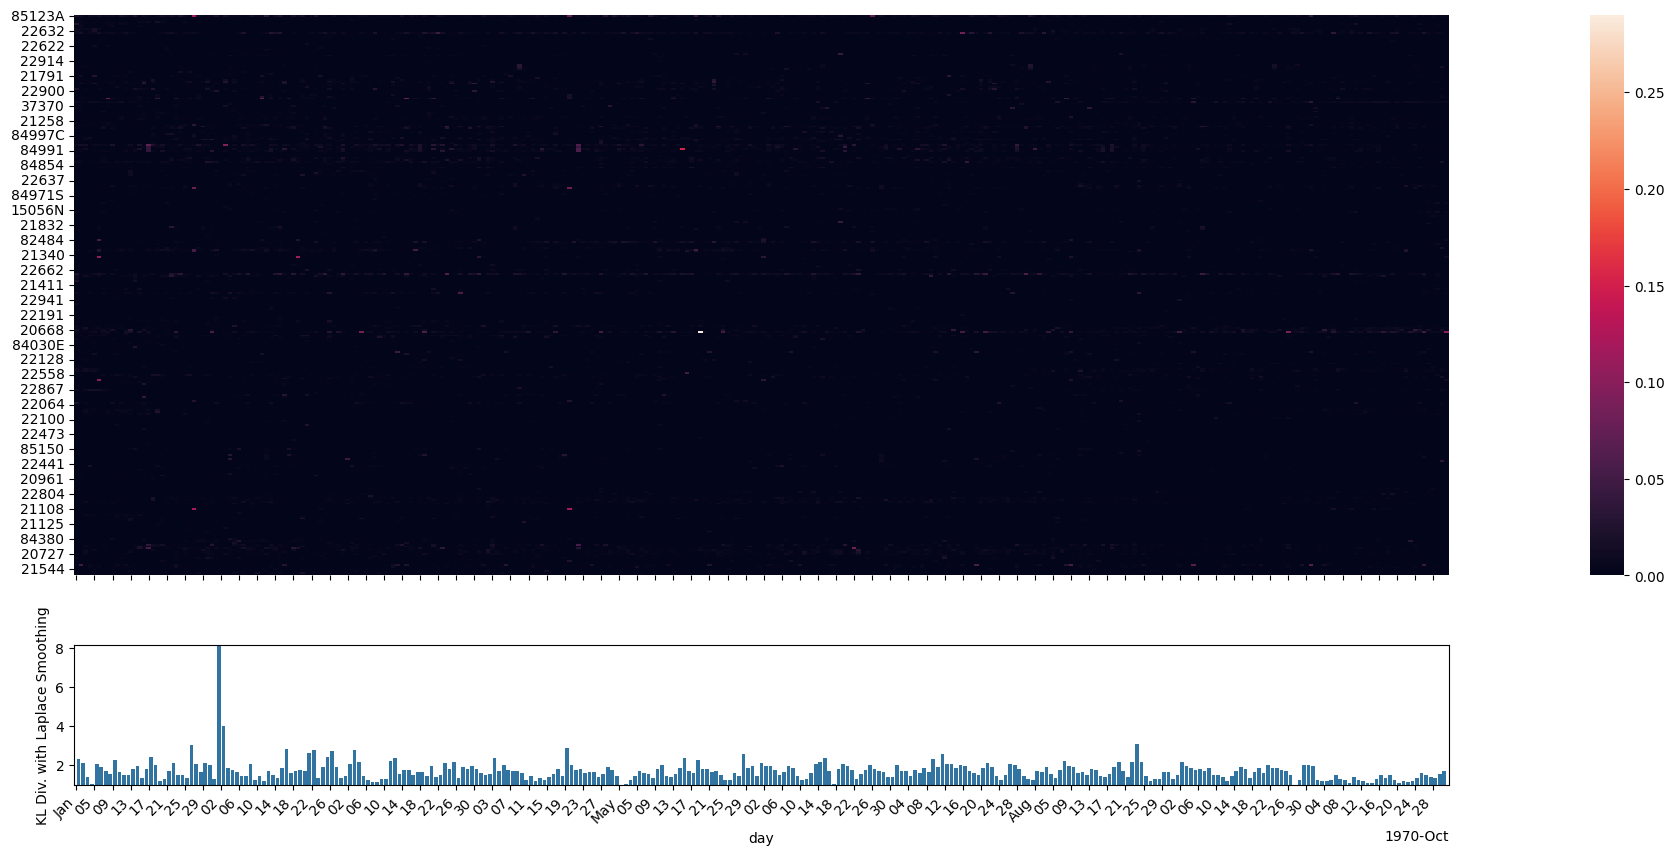

In [ ]:
day_lim = 304
col_lim = 300
div = 'KL Div. with Laplace Smoothing'
fig, ax = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[200,5], 'height_ratios': [4, 1]})
fig.set_size_inches(20, 10)
ax[1,1].remove()
sns.barplot(data=result_df.reset_index().iloc[:day_lim], x='day', y=div, ax=ax[1,0])
sns.heatmap(df.T.iloc[:col_lim, :day_lim], square=False, ax=ax[0,0], cbar_ax=ax[0,1])
ax[1, 0].set_ylim(result_df[div].iloc[1:day_lim].min()-0.01, result_df[div].iloc[:day_lim].max()+0.01)
xlabel_formatter = mpl.dates.ConciseDateFormatter(r'%Y-%m')
ax[1, 0].xaxis.set_major_formatter(xlabel_formatter)
for label in ax[1, 0].get_xticklabels():
    label.set(rotation=45, horizontalalignment='right')

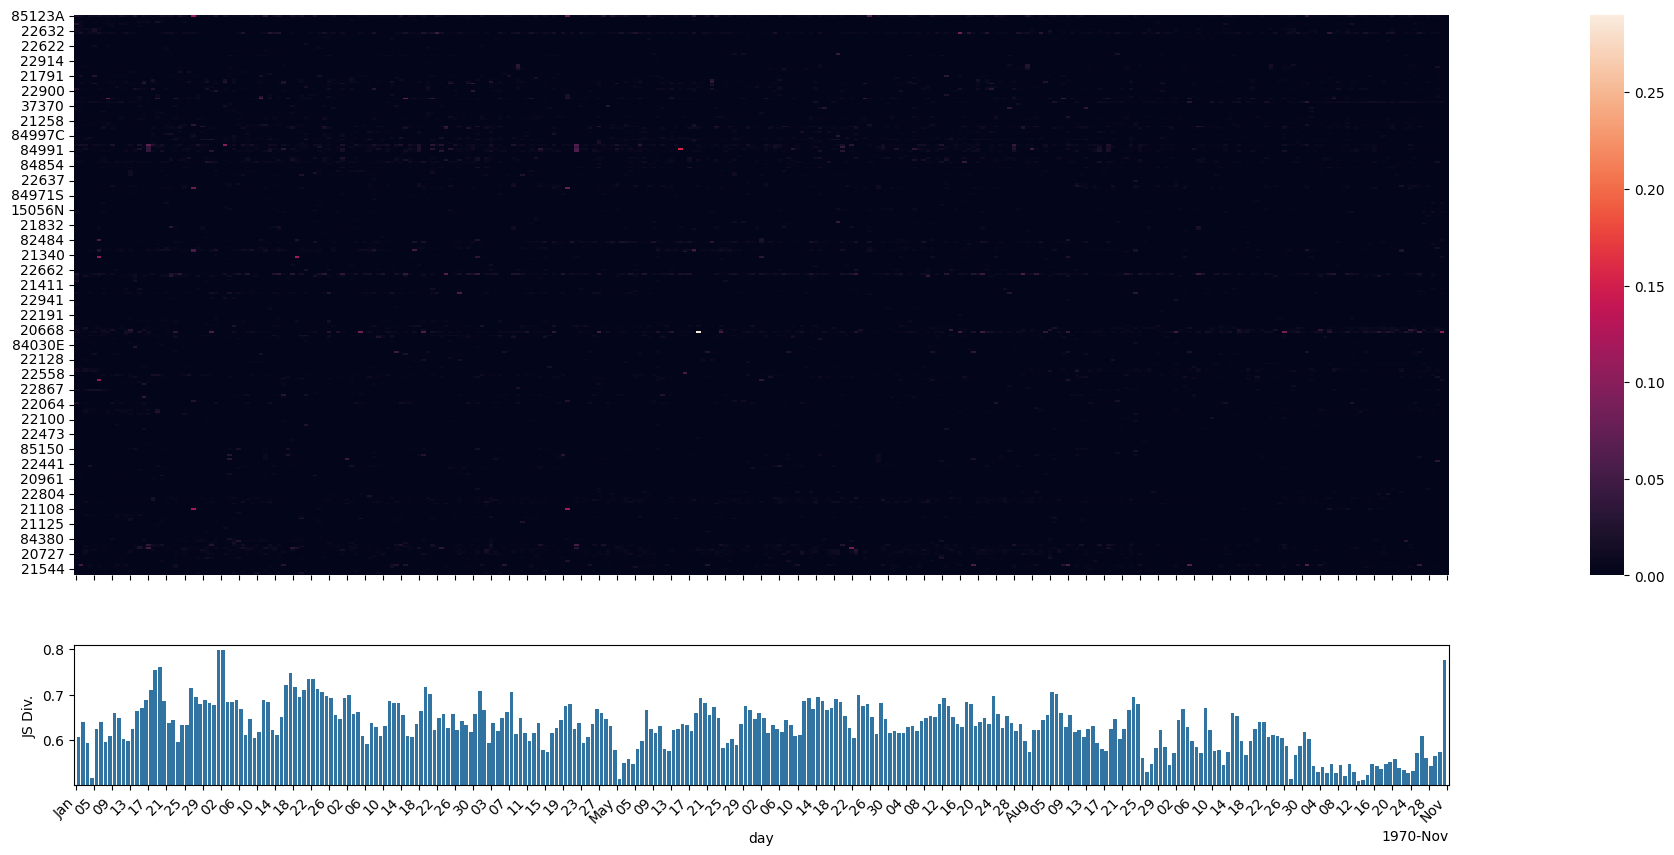

In [ ]:
day_lim = 304
col_lim = 300
div = 'JS Div.'
fig, ax = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[200,5], 'height_ratios': [4, 1]})
fig.set_size_inches(20, 10)
ax[1,1].remove()
sns.barplot(data=result_df.reset_index().iloc[:day_lim], x='day', y=div, ax=ax[1,0])
sns.heatmap(df.T.iloc[:col_lim, :day_lim], square=False, ax=ax[0,0], cbar_ax=ax[0,1])
ax[1, 0].set_ylim(result_df[div].iloc[1:day_lim].min()-0.01, result_df[div].iloc[:day_lim].max()+0.01)
xlabel_formatter = mpl.dates.ConciseDateFormatter(r'%Y-%m')
ax[1, 0].xaxis.set_major_formatter(xlabel_formatter)
for label in ax[1, 0].get_xticklabels():
    label.set(rotation=45, horizontalalignment='right')

In [ ]:
df.to_json('/content/drive/MyDrive/projects/data-hanmadang/time-series.json')

In [ ]:
result_df.to_json('/content/drive/MyDrive/projects/data-hanmadang/time-series-result.json')

In [ ]:
result_df.describe()

,JS Div.,KL Div. with Laplace Smoothing
count,305.000000,305.000000
mean,0.628395,1.704437
std,0.063646,0.681066
min,0.000000,0.000000
25%,0.597753,1.398354
50%,0.631133,1.645916
75%,0.665181,1.885919
max,0.798391,8.702752


### Conclusion
- By the visualization and descriptive statistical values of `result_df`, we can use JS div. KL div. with Laplace smoothing as complementarily. And also we can set the target threshold as _0.5_ in JS Div, _1.2_ in KL Div. When the model's prediction is lower than those values, it means that model predicts far better than simply using yesterday's distribution. This can be interpreted as significant performance.